In [179]:
from datetime import datetime
from datetime import date
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import pandas as pd
import duckdb as db
import  os as os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Sushiswap: https://thegraph.com/explorer/subgraphs/7h1x51fyT5KigAhXd8sdE3kzzxQDJxxz1y66LTFiC3mS?view=Playground
Curve: https://thegraph.com/explorer/subgraphs/GAGwGKc4ArNKKq9eFTcwgd1UGymvqhTier9Npqo1YvZB?view=Playground
Balancer: https://thegraph.com/explorer/subgraphs/Ei5typKWPepPSgqkaKf3p5bPhgJesnu1RuRpyt69Pcrx?view=Overview
Uniswap: https://thegraph.com/explorer/subgraphs/ELUcwgpm14LKPLrBRuVvPvNKHQ9HvwmtKgKSH6123cr7?view=Playground

In [2]:
sg = Subgrounds()
apiKey = file = input('API Key, please')

In [33]:
global file
file = input('Selet a folder to save output') ##enter your file path here - the file is in the repo "summary_stats.csv".

sushi7 = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/7h1x51fyT5KigAhXd8sdE3kzzxQDJxxz1y66LTFiC3mS')

In [180]:
balancer = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/Ei5typKWPepPSgqkaKf3p5bPhgJesnu1RuRpyt69Pcrx')

uniswap = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/ELUcwgpm14LKPLrBRuVvPvNKHQ9HvwmtKgKSH6123cr7')

curve = sg.load_api('https://gateway.thegraph.com/api/'+apiKey+'/subgraphs/id/GAGwGKc4ArNKKq9eFTcwgd1UGymvqhTier9Npqo1YvZB')

In [181]:
frax = sg.load_api('https://api.thegraph.com/subgraphs/name/frax-finance-data/fraxswap-subgraph---mainnet')

In [253]:
balancerEvents = balancer.Query.swaps(
        orderBy='timestamp',
        orderDirection='desc',
        first=1000,
        where={ 'pool_in': ['0xd1ec5e215e8148d76f4460e4097fd3d5ae0a3558','0x76fcf0e8c7ff37a47a799fa2cd4c13cde0d981c9','0x2de32a7c98c3ef6ec79e703500e8ca5b2ec819aa', '0xf5f6fb82649df7991054ef796c39da81b93364df', '0xfb46bc8fc0d06421d362a31b7230f39462efa79a', '0xc45d42f801105e861e86658648e3678ad7aa70f9'],
                'tokenIn':'0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5',
                'tokenOut':'0x6b175474e89094c44da98b954eedeac495271d0f'}

    )

balancerEventsList = sg.query_df([
     balancerEvents.id
    , balancerEvents.timestamp
    , balancerEvents.hash
    , balancerEvents.to
    , balancerEvents._select("from")
    , balancerEvents.tokenIn
    , balancerEvents.amountIn
    , balancerEvents.amountInUSD
    , balancerEvents.tokenOut
    , balancerEvents.amountOut
    , balancerEvents.amountOutUSD
    , balancerEvents.pool.name
])
balancerEventsList['dateTime']=(pd.to_datetime(balancerEventsList['swaps_timestamp'],unit='s'))
balancerEventsList['calDate'] = balancerEventsList['dateTime'].dt.normalize()
balancerEventsList['amountOutReadable'] = balancerEventsList['swaps_amountOut']/(10**(balancerEventsList['swaps_tokenOut_decimals'])).astype('float')
balancerEventsList['amountInReadable'] = balancerEventsList['swaps_amountIn']/(10**(balancerEventsList['swaps_tokenIn_decimals'])).astype('float')
balancerEventsList.head(100)

,swaps_id,swaps_timestamp,swaps_hash,swaps_to,swaps_from,swaps_tokenIn_id,swaps_tokenIn_name,swaps_tokenIn_symbol,swaps_tokenIn_decimals,swaps_tokenIn_lastPriceUSD,...,swaps_tokenOut_decimals,swaps_tokenOut_lastPriceUSD,swaps_tokenOut_lastPriceBlockNumber,swaps_amountOut,swaps_amountOutUSD,swaps_pool_name,dateTime,calDate,amountOutReadable,amountInReadable
0,swap-0xcb59720de776cb0c61db4c1a8ededbb1381e098...,1677085763,0xcb59720de776cb0c61db4c1a8ededbb1381e098a1afc...,0x76fcf0e8c7ff37a47a799fa2cd4c13cde0d981c9,0x877e13f6908ba2d3675fbdd2dc565533911e7c8f,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.046108,...,18,0.999719,16683190,2211216910354997824314,2210.595558,50OHM-50DAI,2023-02-22 17:09:23,2023-02-22,2211.21691,213.281579
1,swap-0x396c02c2b3f7d3f5d56961c6c30a82726cf852e...,1677080363,0x396c02c2b3f7d3f5d56961c6c30a82726cf852e773f2...,0x76fcf0e8c7ff37a47a799fa2cd4c13cde0d981c9,0x4e0ba53a8bd472424bf304dc84503a9c526bf0a4,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.046108,...,18,0.999719,16683190,6641246288742151761609,6639.380099,50OHM-50DAI,2023-02-22 15:39:23,2023-02-22,6641.246289,640.128266
2,swap-0x6054c58ebf0731093a8b7c031e78e8229247e68...,1677074795,0x6054c58ebf0731093a8b7c031e78e8229247e6802926...,0x76fcf0e8c7ff37a47a799fa2cd4c13cde0d981c9,0xc9ec550bea1c64d779124b23a26292cc223327b6,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.046108,...,18,0.999719,16683190,11945176614583029202944,11941.820020,50OHM-50DAI,2023-02-22 14:06:35,2023-02-22,11945.176615,1145.233499
3,swap-0x1305c794480d606bdb3f9429627603ae5659396...,1677031715,0x1305c794480d606bdb3f9429627603ae56593969c65a...,0x76fcf0e8c7ff37a47a799fa2cd4c13cde0d981c9,0x6db752822fb6a8636bc70f502e8f87ea2fd08b32,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.046108,...,18,0.999719,16683190,11836912341779959068506,11834.035972,50OHM-50DAI,2023-02-22 02:08:35,2023-02-22,11836.912342,1134.451631
4,swap-0x8acf7f8ff180de0d57328ac5c87d1633c253974...,1677014747,0x8acf7f8ff180de0d57328ac5c87d1633c25397466abd...,0x76fcf0e8c7ff37a47a799fa2cd4c13cde0d981c9,0x3b25d8e0801df1264a3d3a5f0bb79bbc292a09fb,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.046108,...,18,0.999719,16683190,5707784660010983080051,5706.397668,50OHM-50DAI,2023-02-21 21:25:47,2023-02-21,5707.78466,545.467550
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,swap-0x9a0a702089dbc8592be138025d2fa7eb8192dfd...,1675402979,0x9a0a702089dbc8592be138025d2fa7eb8192dfd0df00...,0x76fcf0e8c7ff37a47a799fa2cd4c13cde0d981c9,0x080086911d8c78008800fae75871a657b77d0082,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.046108,...,18,0.999719,16683190,2611781366580064049933,2613.622672,50OHM-50DAI,2023-02-03 05:42:59,2023-02-03,2611.781367,259.883482
96,swap-0x5aae59675fe01de5966ec93ab39d09575f6ab49...,1675391207,0x5aae59675fe01de5966ec93ab39d09575f6ab49911eb...,0x76fcf0e8c7ff37a47a799fa2cd4c13cde0d981c9,0xa06c3c08a19e51b33309eddfb356c33ead8517a3,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.046108,...,18,0.999719,16683190,2642122663731801567997,2643.985360,50OHM-50DAI,2023-02-03 02:26:47,2023-02-03,2642.122664,262.641795
97,swap-0xd6dcf38f6c58916fd7ff8ae119e0279a46e1655...,1675389299,0xd6dcf38f6c58916fd7ff8ae119e0279a46e16550f554...,0x76fcf0e8c7ff37a47a799fa2cd4c13cde0d981c9,0xa4b8ae1216d010748c007537524e2dd46f38d200,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.046108,...,18,0.999719,16683190,1273489135174099412444,1274.386945,50OHM-50DAI,2023-02-03 01:54:59,2023-02-03,1273.489135,126.560282
98,swap-0xd46cd59b13cc497d0a4e42ae77cd33d4b024ff3...,1675374731,0xd46cd59b13cc497d0a4e42ae77cd33d4b024ff332514...,0x76fcf0e8c7ff37a47a799fa2cd4c13cde0d981c9,0x493374100e511b1b091fa5bace1929dc154fee80,0x64aa3364f17a4d01c6f1751fd97c2bd3d7e7f1d5,Olympus,OHM,9,10.046108,...,18,0.999719,16683190,13331863721294883172862,13341.262685,50OHM-50DAI,2023-02-02 21:52:11,2023-02-02,13331.863721,1320.624925


In [254]:
balancerPath =file+'/balancerDAISwapOutEvents-'+str(date.today().strftime("%b-%d-%Y"))+'.csv'
balancerEventsList.to_csv(balancerPath, index = False)
print('file ',balancerPath, 'saved')

file  C:\Users\ianfe\PycharmProjects\Econohmetrics\DataOuputs/balancerDAISwapOutEvents-Feb-22-2023.csv saved


AxesSubplot(0.125,0.125;0.775x0.755)


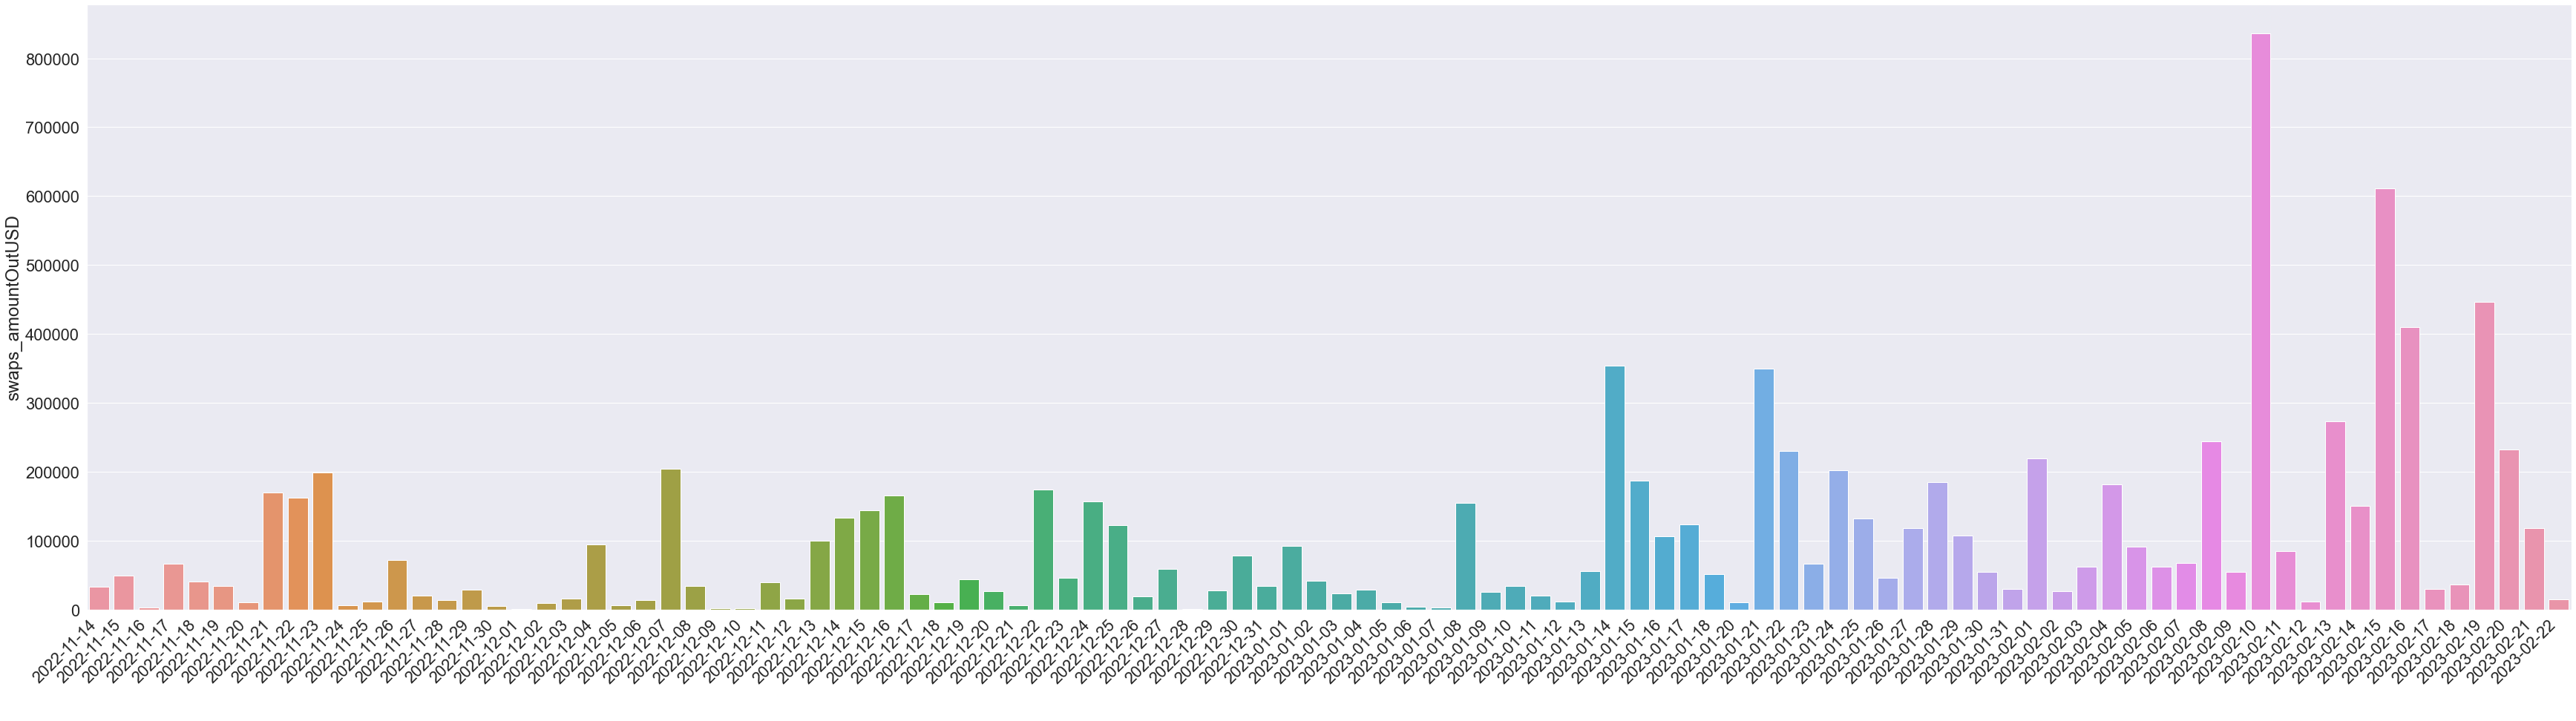

In [255]:
fig, ax = plt.subplots(figsize = (60,15))

fig = sns.barplot(x = "calDate", y = "swaps_amountOutUSD", data = balancerEventsList,
                  estimator = sum, ci = None, ax=ax)
plt.xlabel('Date', fontsize=40, color= 'white')
#ax.tick_params(colors='white', which='both')
x_dates = balancerEventsList['calDate'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

print(fig)
plt.savefig(file+'/dailySwappedOutDAI.png',transparent =False,pad_inches = 1, dpi=100)

In [256]:
dailySwappedDAI = db.query("Select "
                           " calDate "
                           ",sum(cast(amountOutReadable as float)) swappedOutDAI "
                           ",sum(cast(swaps_amountOutUSD as float)) swappedOutUSD "
                           "from balancerEventsList "
                           "Group by 1"
                           "").df()
dailySwappedDAI.head(10)

,calDate,swappedOutDAI,swappedOutUSD
0,2023-02-22,32634.551758,32625.831787
1,2023-02-21,49088.133545,49076.712402
2,2023-02-20,2738.416260,2737.822021
3,2023-02-19,66278.790100,66268.131714
4,2023-02-18,40566.336792,40574.855225
5,2023-02-17,34317.913452,34309.801636
6,2023-02-16,10700.953857,10699.492065
7,2023-02-15,169800.121521,169919.322815
8,2023-02-14,162028.286377,162002.063721
9,2023-02-13,199296.242332,199271.170792


In [257]:
balancerPath =file+'/dailySwappedOutDAI-'+str(date.today().strftime("%b-%d-%Y"))+'.csv'
dailySwappedDAI.to_csv(balancerPath, index = False)
print('file ',balancerPath, 'saved')#and save the chart file, too


file  C:\Users\ianfe\PycharmProjects\Econohmetrics\DataOuputs/dailySwappedOutDAI-Feb-22-2023.csv saved


In [258]:
totalDAIOutUSD = dailySwappedDAI['swappedOutUSD'].sum()
totalDAIOutUSD

9850722.38369529

In [259]:
fraxEvents= frax.Query.swaps(
     orderBy='timestamp'
    ,orderDirection='desc'
    ,first=1000
    ,where={ 'pair': '0x5769071665eb8db80e7e9226f92336bb2897dcfa' }
   # ,where = [frax.Query.swaps.pair.id == '0x5769071665eb8db80e7e9226f92336bb2897dcfa']

#{'users_positions_pair_id':'0x66bf36dba79d4606039f04b32946a260bcd3ff52'}

)
fraxSwapEvents= sg.query_df([
    fraxEvents.id
    ,fraxEvents.transaction.timestamp
    ,fraxEvents.logIndex
    ,fraxEvents.pair.id
    ,fraxEvents.pair.token0.symbol
    ,fraxEvents.pair.token0.decimals
    ,fraxEvents.pair.token1.symbol
    ,fraxEvents.pair.token0.decimals
    ,fraxEvents.pair.token1.decimals
    ,fraxEvents.amount0In
    ,fraxEvents.amount1In
    ,fraxEvents.amount0Out
    ,fraxEvents.amount1Out
    ,fraxEvents.pair.token1.symbol
    ,fraxEvents.amountUSD
    ]
)

fraxSwapEvents['dateTime']=(pd.to_datetime(fraxSwapEvents['swaps_transaction_timestamp'],unit='s'))
fraxSwapEvents['calDate'] = balancerEventsList['dateTime'].dt.normalize()
fraxSwapEvents.head(1000)

,swaps_id,swaps_transaction_timestamp,swaps_logIndex,swaps_pair_id,swaps_pair_token0_symbol,swaps_pair_token0_decimals,swaps_pair_token1_symbol,swaps_pair_token1_decimals,swaps_amount0In,swaps_amount1In,swaps_amount0Out,swaps_amount1Out,swaps_amountUSD,dateTime,calDate
0,0xedf21af8db6d4e70a40377cf80fe1fd6fb52abbc4cf2...,1677014699,110,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,327.958667,0.000000,0.000000,3462.272415,3462.272415,2023-02-21 21:24:59,2023-02-22
1,0xfec262ce50b0db3cdcb3d6d4af6fcd1ac0eb2b916835...,1676968811,101,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,274.359923,0.000000,0.000000,2940.734219,2940.734219,2023-02-21 08:40:11,2023-02-22
2,0x72005e57415f15296e7c368717431d69da552575c630...,1676784467,114,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,0.000000,2551.500000,235.958792,0.000000,2551.500000,2023-02-19 05:27:47,2023-02-22
3,0x2893c62acf19befd6423a8e891a594b9171cbe13d882...,1676670227,153,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,0.000000,1890.228271,176.341427,0.000000,1890.228271,2023-02-17 21:43:47,2023-02-22
4,0x6816d17089eb3590e32a5122d3c6adb3c19502adb80f...,1676601335,203,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,0.000000,30.000000,2.810133,0.000000,30.000000,2023-02-17 02:35:35,2023-02-21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,0x86d1ae3f17e3da45798738cb8d6a909d00852140580f...,1661834547,185,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,0.000000,1423.508811,117.741314,0.000000,1423.508811,2022-08-30 04:42:27,2022-11-28
747,0x9fb3316028539a942cec9ea85d74b1957c0fd2439fa4...,1661804594,71,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,0.000000,712.303543,59.599709,0.000000,712.303543,2022-08-29 20:23:14,2022-11-28
748,0xe817927301184674efc11c991bc937d39eea0460c072...,1661638702,53,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,107.651287,0.000000,0.000000,1292.808993,1292.808993,2022-08-27 22:18:22,2022-11-28
749,0x70734bbd35328d62a386517bbaa3d425ab81dc2577d4...,1661617624,356,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,96.226549,0.000000,0.000000,1175.348784,1172.536084,2022-08-27 16:27:04,2022-11-28


In [260]:
#we only want deposits where OHM is in and FRAX out
fraxSwapEvents.drop(fraxSwapEvents.loc[fraxSwapEvents['swaps_amount0In']==0].index, inplace=True)
fraxSwapEvents.head(10)

,swaps_id,swaps_transaction_timestamp,swaps_logIndex,swaps_pair_id,swaps_pair_token0_symbol,swaps_pair_token0_decimals,swaps_pair_token1_symbol,swaps_pair_token1_decimals,swaps_amount0In,swaps_amount1In,swaps_amount0Out,swaps_amount1Out,swaps_amountUSD,dateTime,calDate
0,0xedf21af8db6d4e70a40377cf80fe1fd6fb52abbc4cf2...,1677014699,110,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,327.958667,0.0,0.0,3462.272415,3462.272415,2023-02-21 21:24:59,2023-02-22
1,0xfec262ce50b0db3cdcb3d6d4af6fcd1ac0eb2b916835...,1676968811,101,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,274.359923,0.0,0.0,2940.734219,2940.734219,2023-02-21 08:40:11,2023-02-22
5,0xd4f1c446c78a12f8329cc4bb38416169470f15ea200f...,1676583755,367,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,353.728338,0.0,0.0,3786.807694,3786.807694,2023-02-16 21:42:35,2023-02-21
9,0x9d153005d579b05e979c41eb8b32460f5d0d4f59be1a...,1676336387,71,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,113.237462,0.0,0.0,1176.529654,1176.529654,2023-02-14 00:59:47,2023-02-21
11,0xdd856a3728d592f141bbf37751719f33461b179f36e3...,1675983923,63,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,204.937388,0.0,0.0,2090.229189,2090.229189,2023-02-09 23:05:23,2023-02-19
13,0x4abc297bc4747083f54f7c15456f14e3554de75d8438...,1675969247,168,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,25.000000,0.0,0.0,250.708931,250.708931,2023-02-09 19:00:47,2023-02-19
14,0xfd43ee3ac2c5341d22187cc38b9248cc3a5e81d9348d...,1675335575,44,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,217.807971,0.0,0.0,2204.726666,2204.726666,2023-02-02 10:59:35,2023-02-19
15,0xebd8ef87a63bff70b582d36c62c5f8f588510d0f5232...,1675335575,49,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,573.000000,0.0,0.0,5695.312692,5695.312692,2023-02-02 10:59:35,2023-02-19
22,0x9a8275200bc30e7a3b376871be1b241fe32b715d698c...,1675079759,43,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,140.700470,0.0,0.0,1382.826264,1382.826264,2023-01-30 11:55:59,2023-02-18
23,0xf93e80fbbb8ca7d151cfb40db74cc5c401f991ce4c64...,1675069415,99,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,210.927753,0.0,0.0,2084.472763,2084.472763,2023-01-30 09:03:35,2023-02-18


In [261]:
#we remove the unnecessary columns :amount1In and amount0Out
fraxSwapEvents.drop(['swaps_amount1In','swaps_amount0Out'],axis=1, inplace=True)
fraxSwapEvents.head(100)

,swaps_id,swaps_transaction_timestamp,swaps_logIndex,swaps_pair_id,swaps_pair_token0_symbol,swaps_pair_token0_decimals,swaps_pair_token1_symbol,swaps_pair_token1_decimals,swaps_amount0In,swaps_amount1Out,swaps_amountUSD,dateTime,calDate
0,0xedf21af8db6d4e70a40377cf80fe1fd6fb52abbc4cf2...,1677014699,110,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,327.958667,3462.272415,3462.272415,2023-02-21 21:24:59,2023-02-22
1,0xfec262ce50b0db3cdcb3d6d4af6fcd1ac0eb2b916835...,1676968811,101,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,274.359923,2940.734219,2940.734219,2023-02-21 08:40:11,2023-02-22
5,0xd4f1c446c78a12f8329cc4bb38416169470f15ea200f...,1676583755,367,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,353.728338,3786.807694,3786.807694,2023-02-16 21:42:35,2023-02-21
9,0x9d153005d579b05e979c41eb8b32460f5d0d4f59be1a...,1676336387,71,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,113.237462,1176.529654,1176.529654,2023-02-14 00:59:47,2023-02-21
11,0xdd856a3728d592f141bbf37751719f33461b179f36e3...,1675983923,63,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,204.937388,2090.229189,2090.229189,2023-02-09 23:05:23,2023-02-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,0x61f282f417550f2846efc884ff7741d604eef4313420...,1669592075,21,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,288.596819,2323.786218,2323.786218,2022-11-27 23:34:35,2023-01-12
208,0x60c6cdde0c79bf0076814f006c5554146b46e61e5def...,1669591391,70,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,221.852916,1799.543480,1799.543480,2022-11-27 23:23:11,2023-01-12
211,0x54575029ab9222a0933ffa9b57e70d1d6a3d375c9455...,1669503383,37,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,513.831568,4154.686819,4154.686819,2022-11-26 22:56:23,2023-01-12
219,0xbae7124d9071ec14256425e59c7c68a2dfacc953b44f...,1669480547,118,0x5769071665eb8db80e7e9226f92336bb2897dcfa,OHM,9,FRAX,18,562.695764,4291.798713,4291.798713,2022-11-26 16:35:47,2023-01-11


In [262]:
fraxPath =file+'/fraxFRAXSwapOutEvents-'+str(date.today().strftime("%b-%d-%Y"))+'.csv'
fraxSwapEvents.to_csv(fraxPath, index = False)
print('file ',fraxPath, 'saved')

file  C:\Users\ianfe\PycharmProjects\Econohmetrics\DataOuputs/fraxFRAXSwapOutEvents-Feb-22-2023.csv saved


In [268]:
dailySwappedFRAX = db.query("Select "
                           " calDate "
                           ",sum(cast(swaps_amount1Out as float)) swappedOuFRAX "
                           ",sum(cast(swaps_amountUSD as float)) swappedOutUSD "
                           "from fraxSwapEvents "
                           "Group by 1"
                           "").df()
dailySwappedFRAX.head(10)

,calDate,swappedOuFRAX,swappedOutUSD
0,2023-02-22,6403.006592,6403.006592
1,2023-02-21,4963.337280,4963.337280
2,2023-02-19,10240.977249,10240.977249
3,2023-02-18,3467.298950,3467.298950
4,2023-02-17,9000.945068,9000.945068
5,2023-02-16,1272.629883,1272.629883
6,2023-02-15,12421.311768,12421.311768
7,2023-02-14,21193.985840,21193.985840
8,2023-02-13,5762.412720,5762.412720
9,2023-02-12,7388.019897,7388.019897


In [269]:
fraxPath = file + '/dailySwappedOutFRAX-' + str(date.today().strftime("%b-%d-%Y")) + '.csv'
dailySwappedFRAX.to_csv(fraxPath, index=False)
print('file ', fraxPath, 'saved')

file  C:\Users\ianfe\PycharmProjects\Econohmetrics\DataOuputs/dailySwappedOutFRAX-Feb-22-2023.csv saved


In [265]:
totalFRAXOutUSD = dailySwappedFRAX['swappedOutUSD'].sum()
totalFRAXOutUSD

1020892.7532615662

In [266]:
totalUSDOut = totalFraxOutUSD+totalDAIOutUSD
print(totalFRAXOutUSD,'FRAX +',totalDAIOutUSD,'=',totalUSDOut)

1020892.7532615662 FRAX + 9850722.38369529 = 10871615.136956856


AxesSubplot(0.125,0.125;0.775x0.755)


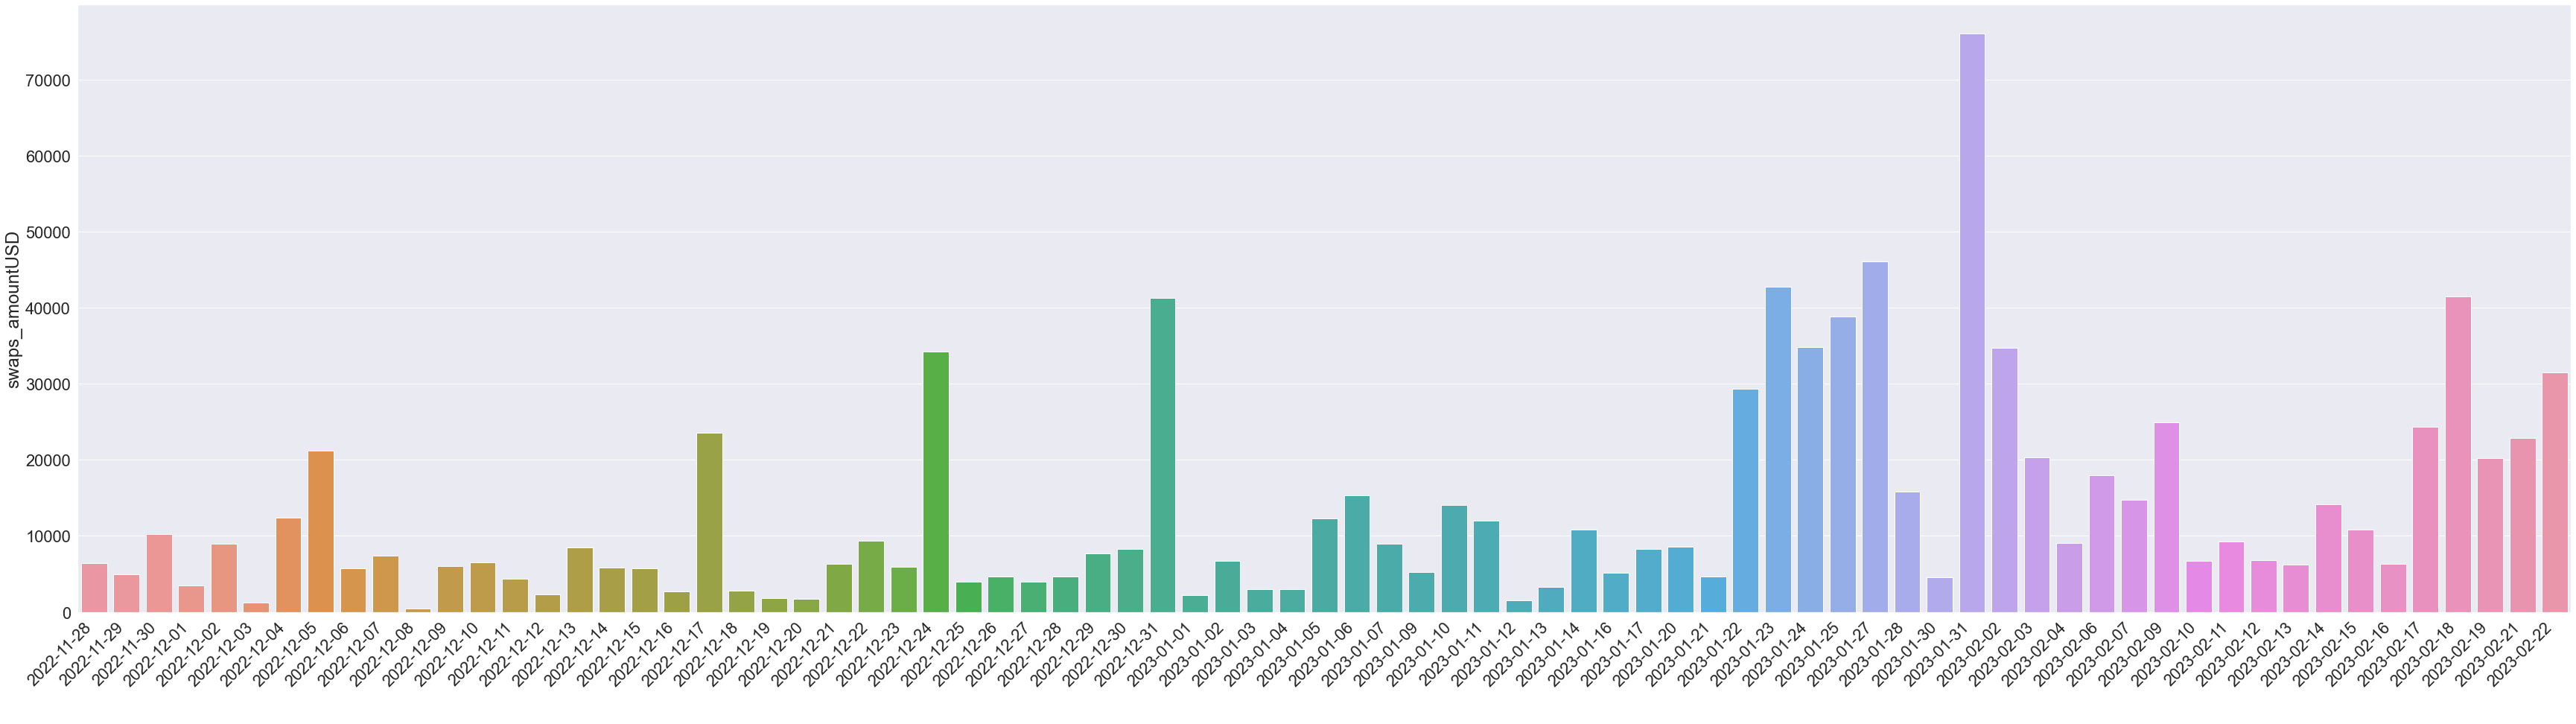

In [267]:
fig, ax = plt.subplots(figsize = (60,15))

fig = sns.barplot(x = "calDate", y = "swaps_amountUSD", data = fraxSwapEvents,
                  estimator = sum, ci = None, ax=ax)
plt.xlabel('Date', fontsize=40, color= 'white')
#ax.tick_params(colors='white', which='both')
x_dates = fraxSwapEvents['calDate'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

print(fig)
plt.savefig(file+'/dailySwappedOutFRAX.png',transparent =False,pad_inches = 1, dpi=100)